In [1]:
from metamod.tasks import MNIST, SemanticTask
from metamod.networks import LRLinearNet
from metamod.trainers import LR_two_layer_training
from metamod.control import LinearNetEq, LRLinearNetControl
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm
import torch

from metamod.utils import plot_lines, plot_weight_ev, check_dir, save_var, get_date_time
from bokeh.palettes import Viridis, Category10, Category20
from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.io import export_svg
output_notebook()

Loading BokehJS ...

In [2]:
run_name = "learning_rate_control"
results_path = "../results"
results_dict = {}
n_steps = 10000#15000
save_weights_every = 20
iter_control = 80
adam_lr = 0.005#0.005  # 0.005 for cost_coef 1e-4

# dataset_params = {"batch_size": 32,
#                   "h_levels": 4}

# dataset_class = SemanticTask

dataset_params = {"batch_size": 32,
                  "new_shape": (5, 5),
                  "subset": (5, 8)}

dataset_class = MNIST

model_params = {"learning_rate": 5e-3,
                "hidden_dim": 50,#30,
                "intrinsic_noise": 0.0,
                "reg_coef": 0.01,
                "W1_0": None,
                "W2_0": None}

control_params = {"control_lower_bound": -1.0,
                  "control_upper_bound": 1.0,
                  "gamma": 1.0,
                  "cost_coef": 0.1,  # 1e-8 for aux, 1e-5 for aux_even_larger
                  "reward_convertion": 1.0,
                  "init_opt_lr": None,
                  "control_lr": adam_lr}  # 0.0005 for cost_coef 0

In [3]:
dataset = dataset_class(**dataset_params)
model_params["input_dim"] = dataset.input_dim
model_params["output_dim"] = dataset.output_dim

# model_params["W1_0"] = np.random.normal(scale=1e-4,
#                                         size=(model_params["hidden_dim"], model_params["input_dim"]))
# model_params["W2_0"] = np.random.normal(scale=1e-4,
#                                         size=(model_params["output_dim"], model_params["hidden_dim"]))

# Init neural network
model = LRLinearNet(**model_params)

In [4]:
iters, loss, test_loss, weights_iter, weights = LR_two_layer_training(model=model, dataset=dataset, n_steps=n_steps,
                                                                      save_weights_every=save_weights_every, return_test=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 855.38it/s]


In [5]:
results_dict["iters"] = iters
results_dict["Loss_t_sim"] = loss
results_dict["weights_sim"] = weights
results_dict["weights_iters_sim"] = weights_iter
results_dict["Loss_t_sim_test"] = test_loss

# Solving equation
init_W1 = weights[0][0, ...]
init_W2 = weights[1][0, ...]

init_weights = [init_W1, init_W2]
input_corr, output_corr, input_output_corr, expected_y, expected_x = dataset.get_correlation_matrix()
input_corr_test, output_corr_test, input_output_corr_test, expected_y_test, expected_x_test = dataset.get_correlation_matrix(training=False)

time_span = np.arange(0, len(iters)) * model_params["learning_rate"]
results_dict["time_span"] = time_span

equation_params = {"in_cov": input_corr,
                   "out_cov": output_corr,
                   "in_out_cov": input_output_corr,
                   "init_weights": init_weights,
                   "in_cov_test": input_corr_test,
                   "out_cov_test": output_corr_test,
                   "in_out_cov_test": input_output_corr_test,
                   "n_steps": n_steps,
                   "reg_coef": model_params["reg_coef"],
                   "intrinsic_noise": model_params["intrinsic_noise"],
                   "learning_rate": model_params["learning_rate"],
                   "time_constant": 1.0}

solver = LinearNetEq(**equation_params)

# Initialize control
control_params = {**control_params, **copy.deepcopy(equation_params)}
control = LRLinearNetControl(**control_params)

In [6]:
W1_t, W2_t = solver.get_weights(time_span, get_numpy=True)
Loss_t = solver.get_loss_function(W1_t, W2_t, get_numpy=True)
Loss_t_test = solver.get_loss_function(W1_t, W2_t, get_numpy=True, use_test=True)

results_dict["W1_t_eq"] = W1_t
results_dict["W2_t_eq"] = W2_t
results_dict["Loss_t_eq"] = Loss_t
results_dict["Loss_t_eq_test"] = Loss_t_test

In [7]:
W1_t_control, W2_t_control = control.get_weights(time_span, get_numpy=True)
Loss_t_control = control.get_loss_function(W1_t_control, W2_t_control, get_numpy=True)
Loss_t_control_test = control.get_loss_function(W1_t, W2_t, get_numpy=True, use_test=True)

results_dict["W1_t_control_init"] = W1_t_control
results_dict["W2_t_control_init"] = W2_t_control
results_dict["Loss_t_control_init"] = Loss_t_control
results_dict["Loss_t_control_init_test"] = Loss_t_control_test
results_dict["control_signal_init"] = control.opt_lr.detach().cpu().numpy()

In [8]:
losses = (loss, Loss_t, Loss_t_control, Loss_t_test, Loss_t_control_test)
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][2], Category10[10][3])
legends = ("Real Non-linear", "Approximation", "Init Control", "eq test", "control test")
alphas = (0.3, 1, 1, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [9]:
control_params["iters_control"] = iter_control
cumulated_reward = []
mean_grad = []

for i in tqdm(range(iter_control)):
    R, grad = control.train_step(get_numpy=True, eval_on_test=False)
    cumulated_reward.append(R)
    mean_grad.append(np.mean(grad**2))
cumulated_reward = np.array(cumulated_reward).astype(float)
results_dict["cumulated_reward_opt"] = cumulated_reward

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [09:34<00:00,  7.19s/it]


In [10]:
opt = plot_lines(np.arange(iter_control), (cumulated_reward,), x_axis_label="gradient steps on control", y_axis_label="Cumulated reward")
show(opt)

In [11]:
W1_t_opt, W2_t_opt = control.get_weights(time_span, get_numpy=True)
Loss_t_opt = control.get_loss_function(W1_t_opt, W2_t_opt, get_numpy=True)
Loss_t_opt_test = control.get_loss_function(W1_t_opt, W2_t_opt, get_numpy=True, use_test=True)

results_dict["W1_t_control_opt"] = W1_t_opt
results_dict["W2_t_control_opt"] = W2_t_opt
results_dict["Loss_t_control_opt"] = Loss_t_opt

In [12]:
losses = (loss, Loss_t, Loss_t_opt, Loss_t_opt_test)
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][2])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control", "test")
alphas = (0.3, 1, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [13]:
opt_lr = (control.opt_lr.detach() + torch.ones(control.opt_lr.shape, dtype=model.dtype, device=model.device))*model_params["learning_rate"]
control_signal = opt_lr
W1_0, W2_0 = control_params["init_weights"]
results_dict["control_signal"] = opt_lr

In [14]:
opt_lr

tensor([0.0068, 0.0068, 0.0068,  ..., 0.0050, 0.0050, 0.0050], device='cuda:0')

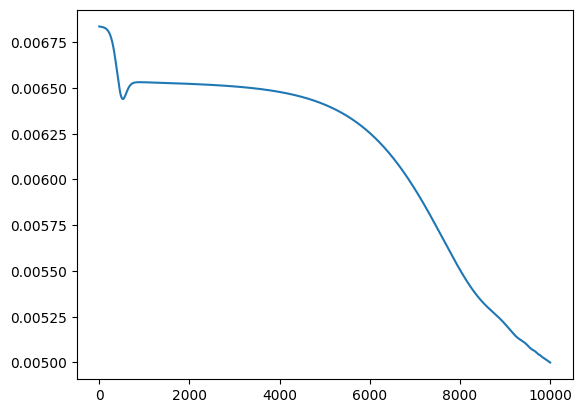

In [15]:
plt.plot(opt_lr.detach().cpu().numpy())

In [16]:
reset_model_params = model_params.copy()
reset_model_params["W1_0"] = W1_0
reset_model_params["W2_0"] = W2_0

reset_model = LRLinearNet(**reset_model_params)

In [17]:
iters, loss_OPT, loss_OPT_test, weights_iter_OPT, weights_OPT  = LR_two_layer_training(model=reset_model, dataset=dataset, n_steps=n_steps,
                                                                                       save_weights_every=save_weights_every,
                                                                                       opt_lr=opt_lr, return_test=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 960.49it/s]


In [18]:
losses = (loss, Loss_t, Loss_t_opt, loss_OPT, loss_OPT_test, Loss_t_opt_test)
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][1], Category10[10][2], Category10[10][2])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control", "Optimized Non-linear", "opt_test_sim", "opt_test")
alphas = (0.3, 1, 1, 0.3, 0.3, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [19]:
W1_t_control, W2_t_control = control.get_weights(control.time_span)
L_t = control.get_loss_function(W1=W1_t_control, W2=W2_t_control, use_test=False)
C_t = control.control_cost()

instant_reward_rate = -control.reward_convertion*L_t-C_t

In [20]:
C_t

tensor([1.3482e-02, 1.3481e-02, 1.3481e-02,  ..., 1.5734e-09, 1.0609e-10,
        0.0000e+00], device='cuda:0', grad_fn=<MulBackward0>)

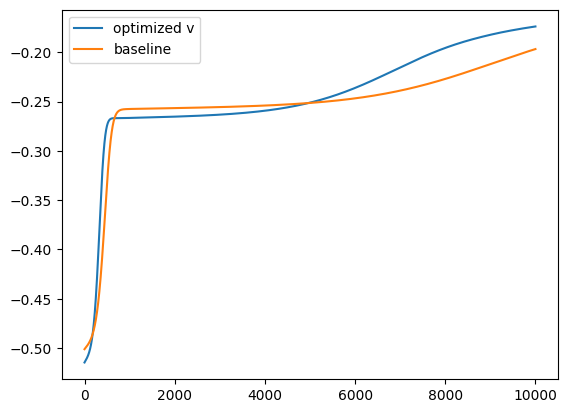

In [21]:
plt.plot(instant_reward_rate.detach().cpu().numpy(), label="optimized v")
plt.plot(-Loss_t, label="baseline")
plt.legend()
plt.show()


In [22]:
control.gamma**(control.time_span)

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [23]:
np.sum(-instant_reward_rate.detach().cpu().numpy())*control.dt, np.sum(Loss_t)*control.dt

(12.16962890625, 12.660310058593751)